# Exploring deaths of notable people by year in Wikipedia
By R. Stuart Geiger, last updated 2016-12-28

Dual-licensed under CC-BY-SA 4.0 and the MIT License.

## How many articles are in the "[year] deaths" categories in the English Wikipedia?

The first thing I tried was just counting up the number of articles in each of the "[[year] deaths](https://en.wikipedia.org/wiki/Category:Deaths_by_year)" categories, from 2000-2016. 

In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
%matplotlib inline
matplotlib.style.use('seaborn-darkgrid')

In [142]:
import pywikibot
site = pywikibot.Site('en', 'wikipedia')

In [143]:
def yearly_death_counts(startyear,endyear):
    years = np.arange(startyear,endyear+1)  # add one to endyear because np.arange doesn't include the stop 
    deaths_per_year = {}
    for year in years:
        deaths_per_year[year] = 0

    for year in years:
        yearstr = 'Category:' + str(year) + "_deaths"
        deathcat = pywikibot.Page(site, yearstr)
        deathcat_o = site.categoryinfo(deathcat)
        deaths_per_year[year] = deathcat_o['pages']

    yearly_articles_df = pd.DataFrame.from_dict(deaths_per_year, orient='index')
    yearly_articles_df.columns = ['articles in category']
    yearly_articles_df = yearly_articles_df.sort_index()
    
    return yearly_articles_df

In [144]:
yearly_articles_df = yearly_death_counts(2000,2016)
yearly_articles_df

,articles in category
2000,4945
2001,5112
2002,5378
2003,5566
2004,5691
2005,6128
2006,6586
2007,6872
2008,7178
2009,7322


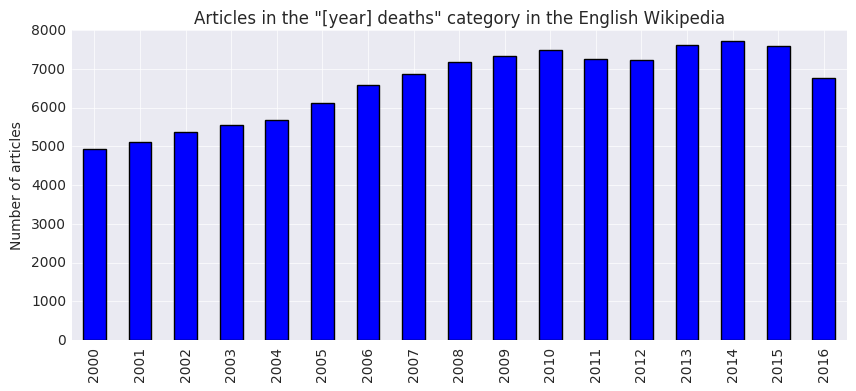

In [145]:
ax = yearly_articles_df.plot(kind='bar',figsize=[10,4])
ax.legend_.remove()
ax.set_ylabel("Number of articles")
ax.set_title("""Articles in the "[year] deaths" category in the English Wikipedia""")

### Interpreting total article counts

One of the first things that we see in this graph is that the data is far from uniform, and has a distinct trend. This should make us suspicious. There are about 4,945 articles in the "2000 deaths" category, and the number steadily rises each year to 7,486 articles in the "2010 deaths" category. Is there any compelling reason we have to believe that the number of notable people in the world would steadily increase by a few percent each year from 2000 to 2010, then plateau? Or is it more of an artifact of what Wikipedia's volunteer editors choose to work on? 

What if we look at this over a much longer timescale, like 1800-2016?

In [81]:
yearly_articles_df = yearly_death_counts(1800,2016)

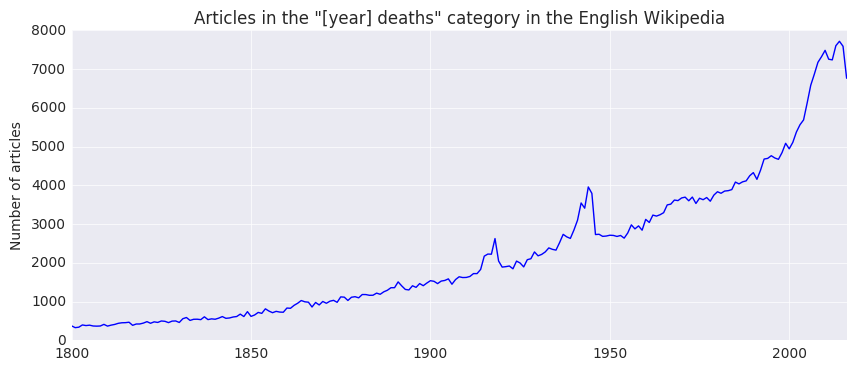

In [96]:
ax = yearly_articles_df.plot(kind='line',figsize=[10,4])
ax.legend_.remove()
ax.set_ylabel("Number of articles")
ax.set_title("""Articles in the "[year] deaths" category in the English Wikipedia""")

We can see the two big jumps in the 20th century, likely reflecting the events around World War I and II. This makes sense, as those time periods were certainly sharp increases in the total number of deaths, as well as the number of notable deaths. Remember: we have already assumed that Wikipedia's biographical articles doesn't represent all of humanity -- in fact, we are counting on it, so we can distinguish celebrity deaths.

However, for the purposes of our question, is it safe to assume that having a Wikipedia article means being a celebrity? When I hear people talk about so many celebrities dying in 2016, people seem to mean a lower number than the ~7,000 people with Wikipedia articles who died in 2010-2016. The number is maybe two orders of magnitude lower, somewhere closer to 70 than 7,000. So is there a way we can filter Wikipedia articles?

To get at this, I first thought of using the pageview data that Wikimedia collects. There is a nice API about how many times every article in every language version of Wikipedia is viewed each hour. I hadn't played around with that API, so I wanted to try it out.

## Pageviews for articles in the "2016 Deaths" category

The mwviews python package has support for hourly, daily, and monthly granularity, but not annual. So I wrote a function that gets the pageview counts for a given article for an entire year. But, as we will see, the data in the historical pageview API only goes back to mid-2015.

In [108]:
!pip install mwviews
from mwviews.api import PageviewsClient

def yearly_views(title,year):
    p = PageviewsClient(2)
    startdate = str(year) + "010100"
    enddate = str(year) + "123123"
    d = p.article_views('en.wikipedia', title, granularity='monthly', start=startdate, end=enddate)
    total = 0
    for month in d.values():
        for titlecount in month.values():
            if titlecount is not None:
                total += titlecount
    return total

In [101]:
yearly_views("Prince_(musician)", 2016)

22810614

In [102]:
yearly_views("Prince_(musician)", 2015)

1642187

In [103]:
yearly_views("Prince_(musician)", 2014)

ERROR while fetching and parsing ['https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/Prince_%28musician%29/daily/2014010100/2014123100']


Traceback (most recent call last):
  File "/srv/paws/lib/python3.4/site-packages/mwviews/api/pageviews.py", line 139, in article_views
    'The pageview API returned nothing useful at: {}'.format(urls)
Exception: The pageview API returned nothing useful at: ['https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/Prince_%28musician%29/daily/2014010100/2014123100']


Exception: The pageview API returned nothing useful at: ['https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/Prince_%28musician%29/daily/2014010100/2014123100']

### Querying the pageview API for all the articles in the "2016 deaths" category

I was wanting to get 2016 pageview data for 2016 deaths, 2015 pageview data for 2015 deaths, and so on. But there isn't full historical data for the pageview API. However, we can take a detour and do some interesting exploration with only the 2016 dataset.

This code iterates through the category for "2016 deaths" and for each page, queries the pageview API to get the number of total pageviews in 2016. It takes a few minutes to run. This throws some errors for a few articles (in pink boxes below), which we will ignore.

In [109]:
year = 2016
yearstr = 'Category:' + str(year) + "_deaths"
deathcat = pywikibot.Page(site, yearstr)

pageviews_2016 = {}

for page in site.categorymembers(deathcat):
    if page.title().find("List_of") is -1 and page.title().find("Category:") is -1:

        try:
            page_yearly_views = yearly_views(page.title(),year)
        except Exception as e:
            page_yearly_views = 0

        pageviews_2016[page.title()] = page_yearly_views

ERROR while fetching and parsing ['https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/Jaume_Camprodon_i_Rovira/daily/2016010100/2016123123']


Traceback (most recent call last):
  File "/srv/paws/lib/python3.4/site-packages/mwviews/api/pageviews.py", line 139, in article_views
    'The pageview API returned nothing useful at: {}'.format(urls)
Exception: The pageview API returned nothing useful at: ['https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/Jaume_Camprodon_i_Rovira/daily/2016010100/2016123123']


ERROR while fetching and parsing ['https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/Koichi_Kato_%28politician%2C_born_1939%29/daily/2016010100/2016123123']


Traceback (most recent call last):
  File "/srv/paws/lib/python3.4/site-packages/mwviews/api/pageviews.py", line 139, in article_views
    'The pageview API returned nothing useful at: {}'.format(urls)
Exception: The pageview API returned nothing useful at: ['https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/Koichi_Kato_%28politician%2C_born_1939%29/daily/2016010100/2016123123']


ERROR while fetching and parsing ['https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/Scott_Eric_Kaufman/daily/2016010100/2016123123']


Traceback (most recent call last):
  File "/srv/paws/lib/python3.4/site-packages/mwviews/api/pageviews.py", line 139, in article_views
    'The pageview API returned nothing useful at: {}'.format(urls)
Exception: The pageview API returned nothing useful at: ['https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/Scott_Eric_Kaufman/daily/2016010100/2016123123']


ERROR while fetching and parsing ['https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/Vladimir_Stupishin/daily/2016010100/2016123123']


Traceback (most recent call last):
  File "/srv/paws/lib/python3.4/site-packages/mwviews/api/pageviews.py", line 139, in article_views
    'The pageview API returned nothing useful at: {}'.format(urls)
Exception: The pageview API returned nothing useful at: ['https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/Vladimir_Stupishin/daily/2016010100/2016123123']


ERROR while fetching and parsing ['https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/Tricia_McCauley/daily/2016010100/2016123123']


Traceback (most recent call last):
  File "/srv/paws/lib/python3.4/site-packages/mwviews/api/pageviews.py", line 139, in article_views
    'The pageview API returned nothing useful at: {}'.format(urls)
Exception: The pageview API returned nothing useful at: ['https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/Tricia_McCauley/daily/2016010100/2016123123']


In [110]:
pageviews_df = pd.DataFrame.from_dict(pageviews_2016,orient='index')
pageviews_df = pageviews_df.sort_values(0, ascending=False)

In [113]:
pageviews_df.head(25)

,0
Deaths in 2016,35737460
Prince (musician),22810614
David Bowie,19095595
Muhammad Ali,16365019
Alan Rickman,9802068
Carrie Fisher,8321692
George Michael,8211608
Fidel Castro,7611586
Jayalalithaa,6104233
Gene Wilder,5918108


In [140]:
pageviews_df.to_csv("enwiki_pageviews_2016.csv")

### Getting the daily pageview counts for 6 most viewed articles in "2016 deaths" (includes the "Deaths in 2016" article)

In [114]:
articles = []
for index,row in pageviews_df.head(6).iterrows():
    articles.append(index)

In [116]:
from mwviews.api import PageviewsClient
p = PageviewsClient(10)

startdate = "2016010100"
enddate = "2016123123"

In [117]:
counts_dict = p.article_views('en.wikipedia', articles, granularity='daily', start=startdate, end=enddate)

In [118]:
counts_df = pd.DataFrame.from_dict(counts_dict, orient='index')
counts_df = counts_df.fillna(0)

In [119]:
counts_df.to_csv("deaths-enwiki-2016.csv")

### Plotting pageviews per day of top 5 articles

In [121]:
articles = []
for index,row in pageviews_df.head(6).iterrows():
    articles.append(index)
    
counts_dict = p.article_views('en.wikipedia', articles, granularity='daily', start=startdate, end=enddate)
counts_df = pd.DataFrame.from_dict(counts_dict, orient='index')
counts_df = counts_df.fillna(0)

  (prop.get_family(), self.defaultFamily[fontext]))



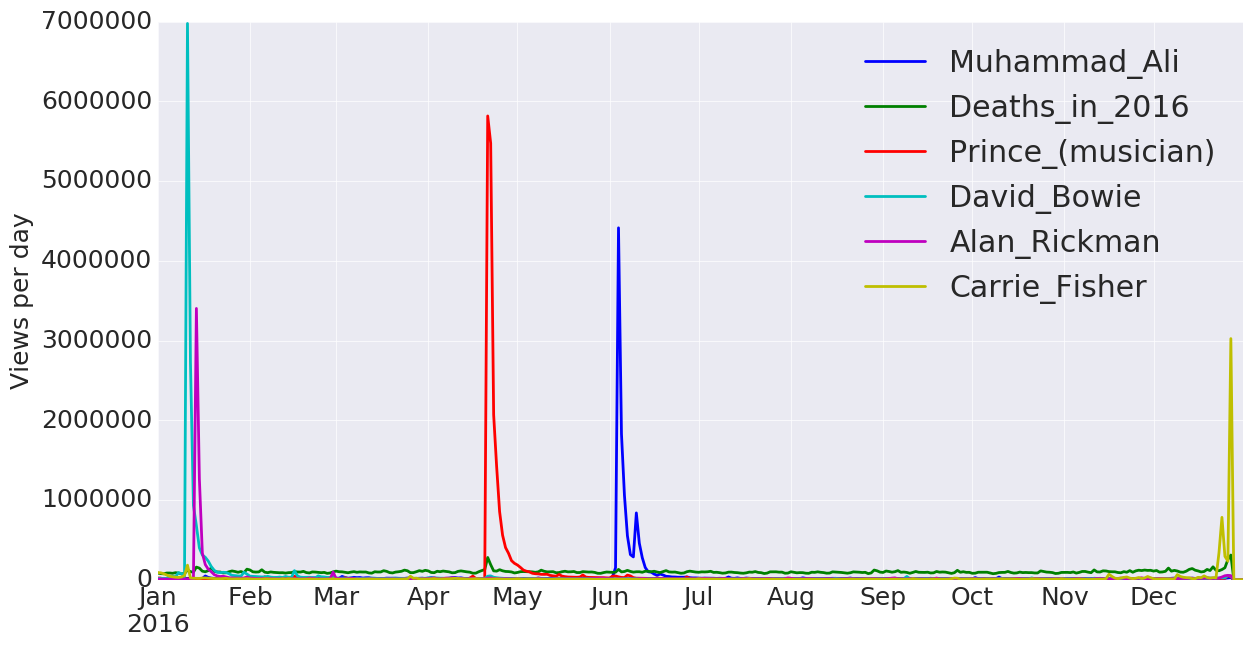

In [122]:
matplotlib.style.use('seaborn-darkgrid')

font = {'family' : 'normal',
        'weight'  : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

plt.figure(figsize=[14,7.2])
for title in counts_df:
    fig = counts_df[title].plot(legend=True, linewidth=2)
    fig.set_ylabel('Views per day')
plt.legend(loc='best')



## Querying edit counts for articles in the "[year] deaths" categories using SQL/Quarry

To get data about the number of times each article the "[year] deaths" categories has been edited, we could use the API, but it would take a long time. There are over 100,000 articles in the 2000-2016 categories, and that would require a new API call for each one. This is the kind of query that SQL is meant for, and we can use the [Quarry](https://quarry.wmflabs.org) service to run this query directly on Wikipedia's servers. 

I've included the query below in a code cell, but it was run [here](https://quarry.wmflabs.org/query/15112). We will download the results in a TSV file, then load it into a pandas dataframe for processing.

In [123]:
sql_query = """
select cl_to, cl_from, count(rev_id) as edits, page_title 
from (select * from categorylinks where cl_to LIKE '20___deaths') as d
inner join revision on cl_from = rev_page
inner join page on rev_page = page_id
where page_namespace = 0 and cl_to NOT LIKE '200s_deaths' and page_title NOT LIKE 'List_of%'
group by cl_from
"""

In [124]:
!wget https://quarry.wmflabs.org/run/139193/output/0/tsv?download=true -O deaths.tsv

--2016-12-28 23:10:48--  https://quarry.wmflabs.org/run/139193/output/0/tsv?download=true
Resolving quarry.wmflabs.org (quarry.wmflabs.org)... 10.68.21.68
Connecting to quarry.wmflabs.org (quarry.wmflabs.org)|10.68.21.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘deaths.tsv’

deaths.tsv              [                <=>   ]   4.47M  1.03MB/s   in 4.6s   

2016-12-28 23:10:53 (997 KB/s) - ‘deaths.tsv’ saved [4686976]



In [125]:
deaths_df = pd.read_csv("deaths.tsv", sep='\t')
deaths_df.columns = ['year', 'page_id', 'edits', 'title']

### Filtering articles by number of edits

We can filter the number of articles in the various death by year categories by the total edit count. But what will be our threshold? What are we looking for? I've chosen 7 different thresholds (over 10, 50, 100, 250, 500, 750, and 1,000 edits). The results these different thresholds produce give rise to different interpretations of the same question.

In [126]:
deaths_over10 = deaths_df[deaths_df.edits>10]
deaths_over50 = deaths_df[deaths_df.edits>50]
deaths_over100 = deaths_df[deaths_df.edits>100]
deaths_over250 = deaths_df[deaths_df.edits>250]
deaths_over500 = deaths_df[deaths_df.edits>500]
deaths_over750 = deaths_df[deaths_df.edits>750]
deaths_over1000 = deaths_df[deaths_df.edits>1000]

In [127]:
deaths_over10 = deaths_over10[['year','edits']]
deaths_over50 = deaths_over50[['year','edits']]
deaths_over100 = deaths_over100[['year','edits']]
deaths_over250 = deaths_over250[['year','edits']]
deaths_over500 = deaths_over500[['year','edits']]
deaths_over750 = deaths_over750[['year','edits']]
deaths_over1000 = deaths_over1000[['year','edits']]

In [131]:
matplotlib.style.use('seaborn-darkgrid')

font = {'family' : 'normal',
        'weight'  : 'normal',
        'size'   : 10}

matplotlib.rc('font', **font)

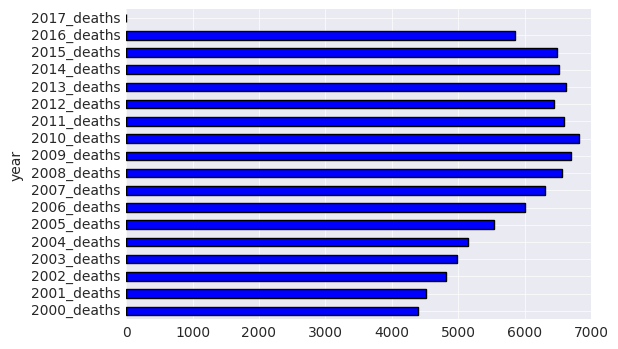

In [133]:
ax = deaths_over10.groupby(['year']).agg(['count']).plot(kind='barh')
ax.legend_.remove()

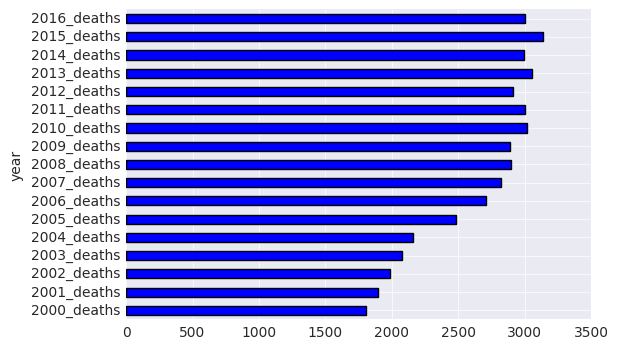

In [134]:
ax = deaths_over50.groupby(['year']).agg(['count']).plot(kind='barh')
ax.legend_.remove()

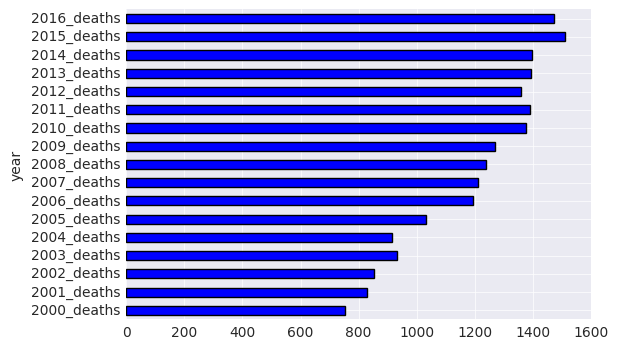

In [135]:
ax = deaths_over100.groupby(['year']).agg(['count']).plot(kind='barh')
ax.legend_.remove()

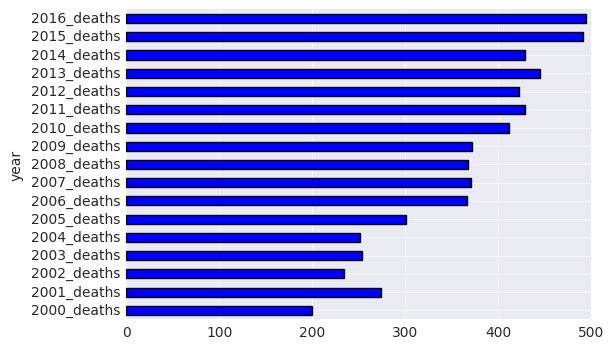

In [136]:
ax = deaths_over250.groupby(['year']).agg(['count']).plot(kind='barh')
ax.legend_.remove()

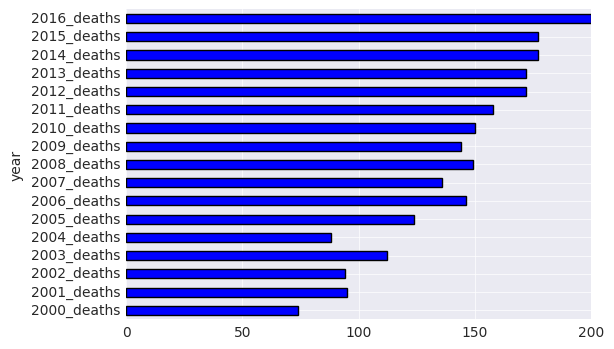

In [137]:
ax = deaths_over500.groupby(['year']).agg(['count']).plot(kind='barh')
ax.legend_.remove()

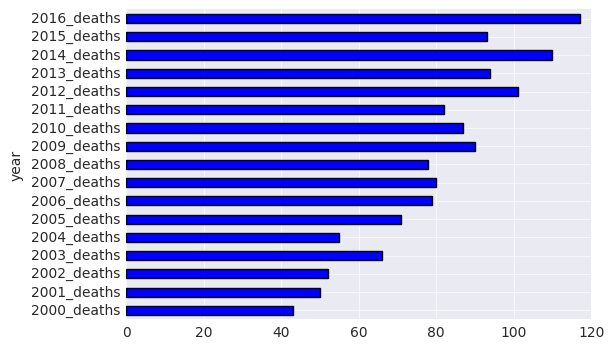

In [138]:
ax = deaths_over750.groupby(['year']).agg(['count']).plot(kind='barh')
ax.legend_.remove()

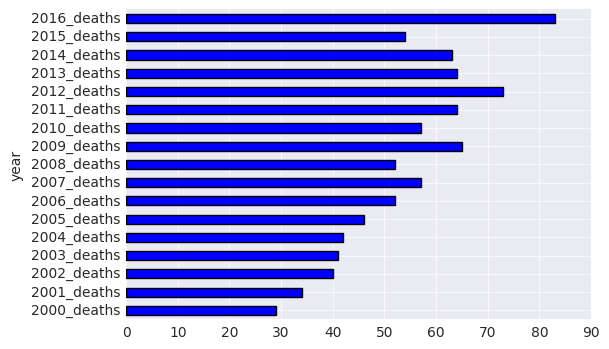

In [139]:
ax = deaths_over1000.groupby(['year']).agg(['count']).plot(kind='barh')
ax.legend_.remove()